# Compare predictions and results
After making recommendaitons and passing them to David, we can compare the predicted titer for our recommendations with their results (i.e. the data from DBTL2).

In [1]:
import edd_utils as eddu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import random
random.seed(1)

In [2]:
fig_loc = './dbtl3ONLY_figures_and_analysis/'

## Import data and recommendations

In [3]:
rec_df = pd.read_csv(f'{fig_loc}/filtered_recs_for_dbtl4.csv', index_col = 0)
rec_df.head(3)

,line_name,pp_mean,pp_std,number_of_grna,in_expt,to_rec
0,PP_0751_PP_0814_PP_1506,419.292418,43.05764,3,0,1
1,PP_0751_PP_0814_PP_4120,419.292418,43.05764,3,0,1
2,PP_0751_PP_0814_PP_1506_PP_4120,418.369692,43.09122,4,0,1


In [4]:
data_df = pd.read_pickle('./isoprenol_data/dbtl4_isoprenol.pkl')
data_df.head(3)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,211976,CRISPRi automation for enhanced isoprenol prod...,211977,4d3d53db-7352-42aa-8303-91a28fcda44b,PP_0368_PP_0812_PP_0813-R1,DBTL4_P1_001,GC-FID,212307,PP_0368_PP_0812_PP_0813-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,458.8593,48.0
1,211976,CRISPRi automation for enhanced isoprenol prod...,211978,a9309f66-2c5f-462b-8c8c-1df3b0152a8d,PP_0368_PP_0812_PP_0815-R1,DBTL4_P1_002,GC-FID,212308,PP_0368_PP_0812_PP_0815-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,713.6108,48.0
2,211976,CRISPRi automation for enhanced isoprenol prod...,211979,6daab9e9-3647-47c9-93dc-d5aa33dc7f2f,PP_0751_PP_0812_PP_0814-R1,DBTL4_P1_003,GC-FID,212309,PP_0751_PP_0812_PP_0814-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,410.4078,48.0


## Format data 

### Drop unneeded columns

In [5]:
columns_to_keep = ['Line Name', 'Value']
data_df = data_df[columns_to_keep]
data_df

,Line Name,Value
0,PP_0368_PP_0812_PP_0813-R1,458.8593
1,PP_0368_PP_0812_PP_0815-R1,713.6108
2,PP_0751_PP_0812_PP_0814-R1,410.4078
3,PP_0751_PP_0813_PP_0814-R1,313.9162
4,PP_0751_PP_0814_PP_4191-R1,351.5461
...,...,...
181,PP_1317_PP_4189-R3,236.1831
182,PP_1506_PP_4189-R3,330.6933
183,PP_4120_PP_4189-R3,16.9408
184,PP_4189_PP_4191-R3,310.2654


In [7]:
np.sort(rec_df['line_name'].unique())

array(['PP_0368_PP_0437_PP_0812', 'PP_0368_PP_0528', 'PP_0368_PP_0751',
       'PP_0368_PP_0751_PP_0814', 'PP_0368_PP_0812_PP_0813',
       'PP_0368_PP_0812_PP_0815', 'PP_0368_PP_0812_PP_1506',
       'PP_0368_PP_0812_PP_1769', 'PP_0368_PP_0812_PP_4120',
       'PP_0368_PP_0812_PP_4192', 'PP_0368_PP_0814', 'PP_0368_PP_0815',
       'PP_0368_PP_0815_PP_1317', 'PP_0368_PP_4189_PP_4192',
       'PP_0368_PP_4191', 'PP_0437_PP_0815_PP_1317',
       'PP_0528_PP_0751_PP_0814', 'PP_0528_PP_0812_PP_0815',
       'PP_0528_PP_0814', 'PP_0528_PP_0815', 'PP_0528_PP_4189',
       'PP_0751_PP_0812_PP_0814', 'PP_0751_PP_0813_PP_0814',
       'PP_0751_PP_0814_PP_1506', 'PP_0751_PP_0814_PP_1506_PP_1769',
       'PP_0751_PP_0814_PP_1506_PP_4120',
       'PP_0751_PP_0814_PP_1769_PP_4120',
       'PP_0751_PP_0814_PP_1769_PP_4192', 'PP_0751_PP_0814_PP_2136',
       'PP_0751_PP_0814_PP_4120', 'PP_0751_PP_0814_PP_4120_PP_4192',
       'PP_0751_PP_0814_PP_4189', 'PP_0751_PP_0814_PP_4191',
       'PP_0751_PP_08

### Add replicate column

In [8]:
data_df['rep'] = data_df['Line Name'].apply(lambda x: int(x[-1]))

### Add line name with no rep

In [9]:
data_df['line_name_norep'] = data_df['Line Name'].apply(lambda x: x.split('-')[0])

### Identify and drop controls

In [10]:
data_df.shape

(186, 4)

In [11]:
data_df['is_control'] = data_df['Line Name'].apply(lambda x: 'ontrol' in x)
data_df = data_df[~data_df['is_control']]

In [12]:
data_df.shape

(174, 5)

In [13]:
data_df.head(3)

,Line Name,Value,rep,line_name_norep,is_control
0,PP_0368_PP_0812_PP_0813-R1,458.8593,1,PP_0368_PP_0812_PP_0813,False
1,PP_0368_PP_0812_PP_0815-R1,713.6108,1,PP_0368_PP_0812_PP_0815,False
2,PP_0751_PP_0812_PP_0814-R1,410.4078,1,PP_0751_PP_0812_PP_0814,False


### Drop lines w/ no predictions

In [14]:
any('PP_0528_PP_0815_PP_1317_PP_4191' == rec_df['line_name'])

False

In [15]:
'PP_0528_PP_0815_PP_1317_PP_4191' in rec_df['line_name']

False

In [16]:
def has_rec(line, all_rec_lines):
    return any(line == all_rec_lines)

data_df.loc[:,'has_rec'] = data_df['line_name_norep'].apply(lambda x: has_rec(x, rec_df['line_name'].unique()))
data_df.head(3)

/tmp/ipykernel_18689/3146226239.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df.loc[:,'has_rec'] = data_df['line_name_norep'].apply(lambda x: has_rec(x, rec_df['line_name'].unique()))


,Line Name,Value,rep,line_name_norep,is_control,has_rec
0,PP_0368_PP_0812_PP_0813-R1,458.8593,1,PP_0368_PP_0812_PP_0813,False,True
1,PP_0368_PP_0812_PP_0815-R1,713.6108,1,PP_0368_PP_0812_PP_0815,False,True
2,PP_0751_PP_0812_PP_0814-R1,410.4078,1,PP_0751_PP_0812_PP_0814,False,True


In [17]:
data_df

,Line Name,Value,rep,line_name_norep,is_control,has_rec
0,PP_0368_PP_0812_PP_0813-R1,458.8593,1,PP_0368_PP_0812_PP_0813,False,True
1,PP_0368_PP_0812_PP_0815-R1,713.6108,1,PP_0368_PP_0812_PP_0815,False,True
2,PP_0751_PP_0812_PP_0814-R1,410.4078,1,PP_0751_PP_0812_PP_0814,False,True
3,PP_0751_PP_0813_PP_0814-R1,313.9162,1,PP_0751_PP_0813_PP_0814,False,True
4,PP_0751_PP_0814_PP_4191-R1,351.5461,1,PP_0751_PP_0814_PP_4191,False,True
...,...,...,...,...,...,...
180,PP_0815_PP_4189-R3,552.4192,3,PP_0815_PP_4189,False,True
181,PP_1317_PP_4189-R3,236.1831,3,PP_1317_PP_4189,False,True
182,PP_1506_PP_4189-R3,330.6933,3,PP_1506_PP_4189,False,True
183,PP_4120_PP_4189-R3,16.9408,3,PP_4120_PP_4189,False,True


In [18]:
data_df = data_df[data_df['has_rec']]
data_df.shape

(171, 6)

## make dataframe for predictions and data

In [19]:
df = pd.DataFrame(columns = ['line'])
df['line'] = data_df['line_name_norep'].unique()
df.head(3)

,line
0,PP_0368_PP_0812_PP_0813
1,PP_0368_PP_0812_PP_0815
2,PP_0751_PP_0812_PP_0814


### Add experimental data to df

In [20]:
df.loc[:, 'mean'] = df['line'].apply(lambda x: 
                                     np.mean(
                                         data_df.loc[data_df['line_name_norep'] == x, 'Value']
                                     ))

df.loc[:, 'std'] = df['line'].apply(lambda x: 
                                     np.std(
                                         data_df.loc[data_df['line_name_norep'] == x, 'Value']
                                     ))

### Add predictions to df

In [21]:
rec_df.head(3)

,line_name,pp_mean,pp_std,number_of_grna,in_expt,to_rec
0,PP_0751_PP_0814_PP_1506,419.292418,43.05764,3,0,1
1,PP_0751_PP_0814_PP_4120,419.292418,43.05764,3,0,1
2,PP_0751_PP_0814_PP_1506_PP_4120,418.369692,43.09122,4,0,1


In [24]:
# rec_df.loc[rec_df['line_name'] == 'PP_0528_PP_0813_PP_0815_PP_1317', 'pp_mean'].values[0]

In [25]:
df.loc[:, 'pred_mean'] = df['line'].apply(lambda x: 
                                         rec_df.loc[rec_df['line_name'] == x, 'pp_mean']
                                     ).values[0]

df.loc[:, 'pred_std'] = df['line'].apply(lambda x: 
                                         rec_df.loc[rec_df['line_name'] == x, 'pp_std']
                                     ).values[0]


In [26]:
for idx, srs in df.iterrows():
    pred_mean_values = rec_df.loc[rec_df['line_name'] == srs['line'], 'pp_mean'].values
    pred_std_values = rec_df.loc[rec_df['line_name'] == srs['line'], 'pp_std'].values

    if len(pred_mean_values) == 1:
        df.loc[idx, 'pred_mean'] = pred_mean_values[0]
        df.loc[idx, 'pred_std'] = pred_std_values[0]
        

In [27]:
df.head(3)

,line,mean,std,pred_mean,pred_std
0,PP_0368_PP_0812_PP_0813,433.548333,17.942007,360.686524,43.029011
1,PP_0368_PP_0812_PP_0815,679.829500,23.913341,372.039564,43.639968
2,PP_0751_PP_0812_PP_0814,395.385000,11.018054,400.225735,43.471583


<Axes: xlabel='mean', ylabel='pred_mean'>

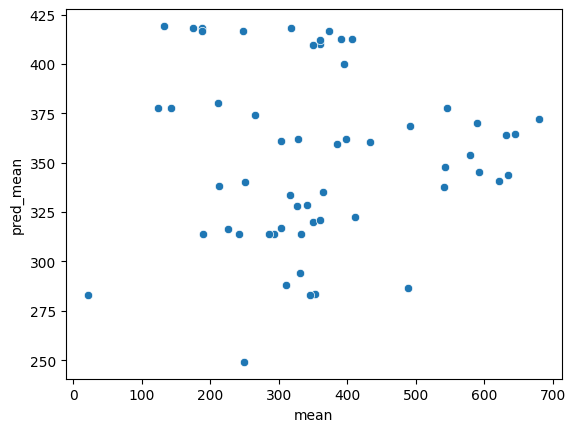

In [28]:
sns.scatterplot(data = df, x = 'mean', y = 'pred_mean')

/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype)

Text(200, 100, 'Pearson R = 0.012\np = 0.927\nR^2 = -0.080\nMAE = 118.505')

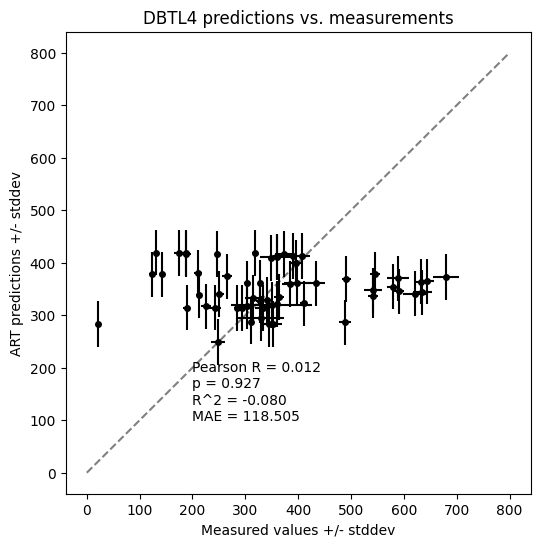

In [32]:
from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_absolute_error


fig, ax = plt.subplots(figsize = (6,6))
plt.plot([0, 800], [0, 800], color = 'grey', linestyle = '--')

plt.errorbar(x = df['mean'], xerr=df['std'], y = df['pred_mean'], yerr = df['pred_std'],
             linestyle = '', marker = '.', markersize = 8, markerfacecolor = 'k', markeredgecolor = 'k', ecolor = 'k')
ax.set_ylabel('ART predictions +/- stddev')
ax.set_xlabel('Measured values +/- stddev')

s,p = pearsonr(df['mean'], df['pred_mean'])
r2 = r2_score(df['mean'], df['pred_mean'])
mae = mean_absolute_error(df['mean'], df['pred_mean'])
ax.set_title(f"DBTL4 predictions vs. measurements")
ax.text(200, 100, f"Pearson R = {s:.3f}\np = {p:.3f}\nR^2 = {r2:.3f}\nMAE = {mae:.3f}")

## Look at rank order of predictions

In [37]:
df['pred_mean_rank'] = df['pred_mean'].rank().astype(int)

<Axes: xlabel='mean', ylabel='pred_mean_rank'>

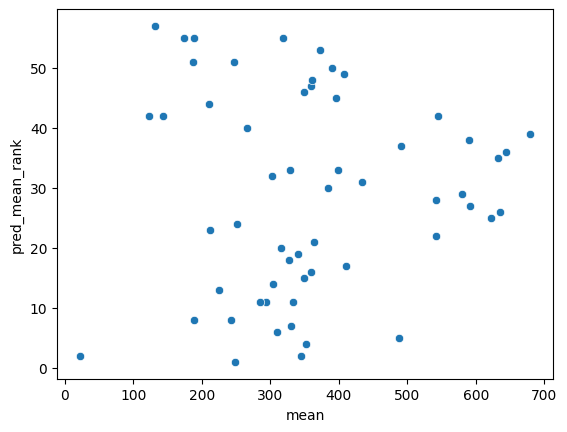

In [38]:
sns.scatterplot(data = df, x = 'mean', y = 'pred_mean_rank')